In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [6]:
json_file = "user-wallet-transactions (1).json"  

In [7]:
with open(json_file, "r") as f:
    transactions = json.load(f)

In [8]:
df = pd.json_normalize(transactions)

In [9]:
df.head()

,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,__v,_id.$oid,...,actionData.repayerId,actionData.liquidatorId,actionData.collateralAmount,actionData.collateralAssetPriceUSD,actionData.principalAmount,actionData.borrowAssetPriceUSD,actionData.collateralReserveId,actionData.collateralReserveSymbol,actionData.principalReserveId,actionData.principalReserveSymbol
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,0,681d38fed63812d4655f571a,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,0,681aa70dd6df53021cc6f3c0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,0,681d04c2d63812d4654c733e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,0,681d133bd63812d46551b6ef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,0,681899e4ba49fc91cf2f4454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Compute USD value for each transaction
df["amount_usd"] = pd.to_numeric(df["actionData.amount"], errors="coerce") * \
                   pd.to_numeric(df["actionData.assetPriceUSD"], errors="coerce")

In [11]:
df["action"] = df["action"].str.lower().str.strip()

In [12]:
# Aggregate by wallet & action
agg_df = df.groupby(["userWallet", "action"]).agg(
    total_usd=("amount_usd", "sum"),
    count=("amount_usd", "count")
).reset_index()

In [13]:
# Pivot into wide format
pivot_df = agg_df.pivot_table(
    index="userWallet",
    columns="action",
    values=["total_usd", "count"],
    fill_value=0
)

In [14]:
pivot_df.columns = [f"{a}_{b}" for a, b in pivot_df.columns]
pivot_df.reset_index(inplace=True)

In [15]:
# Rename to clean feature names
wallet_df = pivot_df.rename(columns={
    "total_usd_deposit": "total_deposit_usd",
    "total_usd_borrow": "total_borrow_usd",
    "count_deposit": "num_deposits",
    "count_borrow": "num_borrows",
    "count_liquidationcall": "num_liquidations",
    "count_repay": "num_repays"
}).fillna(0)

In [16]:
wallet_df.head()

,userWallet,num_borrows,num_deposits,num_liquidations,count_redeemunderlying,num_repays,total_borrow_usd,total_deposit_usd,total_usd_liquidationcall,total_usd_redeemunderlying,total_usd_repay
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,0.0,1.0,0.0,0.0,0.0,0.000000e+00,1.987664e+09,0.0,0.000000e+00,0.000000e+00
1,0x000000000051d07a4fb3bd10121a343d85818da6,0.0,1.0,0.0,0.0,0.0,0.000000e+00,2.856945e+20,0.0,0.000000e+00,0.000000e+00
2,0x000000000096026fb41fc39f9875d164bd82e2dc,0.0,2.0,0.0,0.0,0.0,0.000000e+00,5.152311e+15,0.0,0.000000e+00,0.000000e+00
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.0,0.0,0.0,17.0,0.0,0.000000e+00,0.000000e+00,0.0,9.803600e+20,0.000000e+00
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,15.0,250.0,0.0,130.0,4.0,6.029762e+22,2.065773e+23,0.0,1.128745e+23,7.015026e+10


In [17]:
wallet_df["label"] = np.where(
    (wallet_df["total_deposit_usd"] > wallet_df["total_borrow_usd"]) &
    (wallet_df.get("num_liquidations", 0) == 0),
    1,
    0
)

In [18]:
print(wallet_df["label"].value_counts())

label
1    3151
0     346
Name: count, dtype: int64


In [19]:
wallet_df.head()

,userWallet,num_borrows,num_deposits,num_liquidations,count_redeemunderlying,num_repays,total_borrow_usd,total_deposit_usd,total_usd_liquidationcall,total_usd_redeemunderlying,total_usd_repay,label
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,0.0,1.0,0.0,0.0,0.0,0.000000e+00,1.987664e+09,0.0,0.000000e+00,0.000000e+00,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,0.0,1.0,0.0,0.0,0.0,0.000000e+00,2.856945e+20,0.0,0.000000e+00,0.000000e+00,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,0.0,2.0,0.0,0.0,0.0,0.000000e+00,5.152311e+15,0.0,0.000000e+00,0.000000e+00,1
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.0,0.0,0.0,17.0,0.0,0.000000e+00,0.000000e+00,0.0,9.803600e+20,0.000000e+00,0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,15.0,250.0,0.0,130.0,4.0,6.029762e+22,2.065773e+23,0.0,1.128745e+23,7.015026e+10,1


In [20]:
features = [
    "total_deposit_usd",
    "total_borrow_usd",
    "num_deposits",
    "num_borrows",
    "num_liquidations",
    "num_repays"
]

In [21]:
X = wallet_df[features]
y = wallet_df["label"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

In [24]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        69
           1       0.99      1.00      0.99       631

    accuracy                           0.99       700
   macro avg       0.99      0.93      0.96       700
weighted avg       0.99      0.99      0.99       700



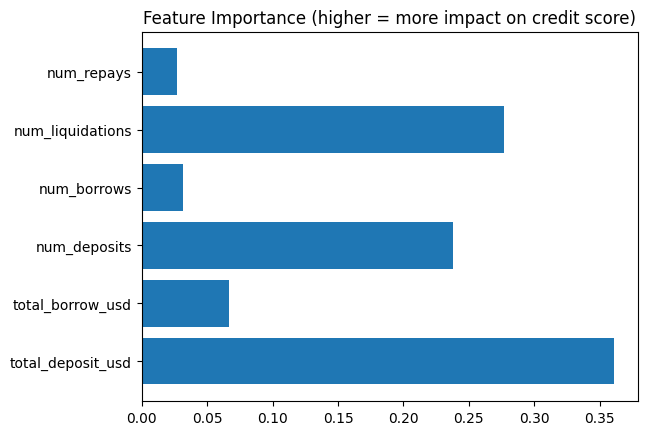

In [26]:
importances = rf.feature_importances_
plt.barh(features, importances)
plt.title("Feature Importance (higher = more impact on credit score)")
plt.show()

In [27]:
proba_good = rf.predict_proba(X)[:, 1]

In [28]:
# Scale probabilities to realistic credit score 300-1000
scaler = MinMaxScaler(feature_range=(300, 1000))
wallet_df["credit_score"] = scaler.fit_transform(proba_good.reshape(-1, 1)).flatten().astype(int)

In [30]:
wallet_df.sort_values("credit_score", ascending=False).sample(11)

,userWallet,num_borrows,num_deposits,num_liquidations,count_redeemunderlying,num_repays,total_borrow_usd,total_deposit_usd,total_usd_liquidationcall,total_usd_redeemunderlying,total_usd_repay,label,credit_score
386,0x008f1edc31890f9c66d4b9cf24c78dd651502274,8.0,24.0,0.0,9.0,4.0,5.534443e+19,1.903187e+20,0.0,2.084788e+20,5.582528e+19,1,979
2350,0x040be472268e720f945eb95a0e71445a0f07aa3f,0.0,3.0,0.0,0.0,0.0,0.000000e+00,3.040239e+06,0.0,0.000000e+00,0.000000e+00,1,1000
1103,0x01d04f947cf6e5e4ffb9d76b40ed83daafa76e5a,0.0,1.0,0.0,0.0,0.0,0.000000e+00,1.994477e+06,0.0,0.000000e+00,0.000000e+00,1,999
2386,0x0417beec20510b679ec207a0ee12720ee924b772,8.0,6.0,0.0,0.0,1.0,3.971981e+20,2.427093e+21,0.0,0.000000e+00,5.006459e+08,1,981
1094,0x01cc647103f4ce8a8f7985df8101d24aab029bf3,0.0,0.0,0.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,7.263896e+10,0.000000e+00,0,300
2430,0x042b79eced8518e0357d790d4363ebb6fbfb1eb2,0.0,2.0,0.0,0.0,0.0,0.000000e+00,1.266641e+23,0.0,0.000000e+00,0.000000e+00,1,1000
360,0x00861fefcfef0a542b0a6c90ce1ee575e257a6c7,10.0,38.0,0.0,12.0,6.0,1.080475e+21,9.417591e+21,0.0,1.086420e+21,1.089095e+21,1,985
2021,0x03692b33a187d69661b0f5b1cd0244702c340fe5,0.0,1.0,0.0,0.0,0.0,0.000000e+00,1.313121e+18,0.0,0.000000e+00,0.000000e+00,1,1000
469,0x00b5ae14450bfd084a00599b6875496aec543e39,0.0,1.0,0.0,0.0,0.0,0.000000e+00,1.081002e+18,0.0,0.000000e+00,0.000000e+00,1,1000
2385,0x0417b1639b07f21535494bef99e086c785675d5f,0.0,4.0,0.0,0.0,0.0,0.000000e+00,5.026599e+18,0.0,0.000000e+00,0.000000e+00,1,1000


In [31]:
# ## 7. Save Final Wallet Scores as JSON

# %%
wallet_scores = {
    row.userWallet: {
        "credit_score": int(row.credit_score),
        "features": {
            "total_deposit_usd": float(row.total_deposit_usd),
            "total_borrow_usd": float(row.total_borrow_usd),
            "num_deposits": int(row.num_deposits),
            "num_borrows": int(row.num_borrows),
            "num_liquidations": int(row.num_liquidations),
            "num_repays": int(row.num_repays)
        }
    }
    for _, row in wallet_df.iterrows()
}

with open("wallet_scores_ml.json", "w") as f:
    json.dump(wallet_scores, f, indent=2)

print("✅ Saved ML-based credit scores to wallet_scores_in_json_ml.json")

✅ Saved ML-based credit scores to wallet_scores_ml.json
